# 10.3 영어/한국어 Word2Vec 실습
이번 챕터에서는 영어와 한국어 훈련 데이터에 대해서 Word2Vec을 학습해보겠습니다. gensim 패키지에서 Word2Vec은 이미 구현되어져 있으므로, 별도로 Word2Vec을 구현할 필요없이 손쉽게 훈련시킬 수 있습니다.

### 1. 영어 Word2Vec 만들기
이번에는 영어 데이터를 다운로드 받아 직접 Word2Vec 작업을 진행해보겠습니다. 파이썬의 gensim 패키지에는 Word2Vec을 지원하고 있어, gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환시킬 수 있습니다. 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행하겠습니다.

##### 1) 훈련 데이터 이해하기
링크 : https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip

위 링크에서 훈련 데이터를 다운로드 받을 수 있습니다. 위 zip 파일의 압축을 풀면 ted_en-20160408.xml이라는 파일이 있는데, 이를 훈련 데이터로 사용할 예정입니다.

xml 문법으로 작성되어져 있는 데이터이므로 자연어를 얻기 위해서는 전처리가 필요합니다. 얻고자 하는 실질적 데이터는 영어 문장으로만 구성된 <content>와 </content> 사이의 내용입니다. 해야할 일은 크게 두 가지네요. 첫째, 전처리 작업을 통해 xml 문법들은 제거합니다. 둘째, <content>와 </content> 사이 내용 중 (Laughter)나 (Applause)와 같은 배경음을 나타내는 단어들을 제거해야 합니다.

##### 2) 데이터 로드 및 전처리하기
데이터를 다운로드하고, xml 파일로부터 필요한 내용만을 가져와 저장합니다.

In [1]:
import re
from lxml import etree
import urllib.request
import zipfile
from nltk.tokenize import word_tokenize, sent_tokenize

In [8]:
with open("../../data/ted_en-20160408.xml", 'rb') as z:
    target_text = etree.parse(z)
    parse_text = '\n'.join(target_text.xpath('//content/text()'))

In [11]:
parse_text[:300]

"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

In [18]:
content_text = re.sub(r'\([^)]*\)', '', parse_text)
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.

sent_text = sent_tokenize(content_text)
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.

normalized_text =[]
for string in sent_text:
    tokens = re.sub(r'[^a-z0-9]+',' ',string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.

result = [word_tokenize(sentence) for sentence in normalized_text]  

In [19]:
print('\nCount of total samples : {}'.format(len(result)))


Count of total samples : 273424


In [20]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


상위 3개 문장만 출력해보았는데 토큰화가 수행되었음을 볼 수 있습니다. 이제 Word2Vec 모델에 텍스트 데이터를 훈련시킵니다.

##### 3) Word2Vec 훈련시키기

In [21]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4,sg=0)

여기서 Word2Vec의 하이퍼파라미터값은 다음과 같습니다.
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

이제 Word2Vec에 대해서 학습을 진행하였습니다. Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원합니다. man과 가장 유사한 단어들은 어떤 단어들일까요?

In [22]:
model_result = model.wv.most_similar('man')
print(model_result)

[('woman', 0.8475466966629028), ('guy', 0.8234093189239502), ('boy', 0.7667437791824341), ('girl', 0.7600693702697754), ('lady', 0.7567564249038696), ('soldier', 0.7446755170822144), ('kid', 0.711570143699646), ('gentleman', 0.7022470831871033), ('surgeon', 0.6656428575515747), ('poet', 0.6641961336135864)]


man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력하는 것을 볼 수 있습니다. 이제 Word2Vec를 통해 단어의 유사도를 계산할 수 있게 되었습니다.

##### 4) Word2Vec 모델 저장하고 로드하기
공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠습니다. 이 모델을 가지고 시각화 챕터에서 시각화를 진행할 예정이므로 꼭 저장해주세요.

In [23]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v')
loaded_model = KeyedVectors.load_word2vec_format('eng_w2v')

In [24]:
model_result = loaded_model.most_similar('man')
print(model_result)

[('woman', 0.8475466966629028), ('guy', 0.8234093189239502), ('boy', 0.7667437791824341), ('girl', 0.7600693702697754), ('lady', 0.7567564249038696), ('soldier', 0.7446755170822144), ('kid', 0.711570143699646), ('gentleman', 0.7022470831871033), ('surgeon', 0.6656428575515747), ('poet', 0.6641961336135864)]


### 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [26]:
import urllib.request
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
urllib.request.urlretrieve('https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt', filename='10.3.ratings.txt')

('10.3.ratings.txt', <http.client.HTTPMessage at 0x7fe6828935c0>)

In [28]:
train_data = pd.read_table('10.3.ratings.txt')

In [29]:
train_data[:3]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1


In [31]:
print(len(train_data))

200000


In [33]:
print(train_data.isnull().values.any())

True


In [35]:
train_data = train_data.dropna(how='any') # null값이 존재하는 행 제거
print(train_data.isnull().values.any())
print(len(train_data))

False
199992


In [36]:
# 정규식을 이용하여 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')

In [37]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [38]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [40]:
# Tokenize
okt = Okt()
tokenized_data =[]

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [ word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)


Max length of review : 68
Average length of review :  10.669446777871116


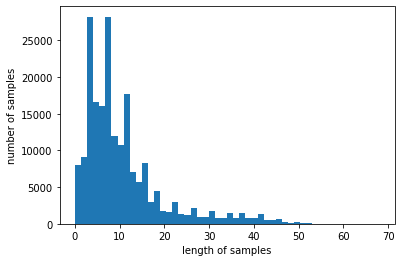

In [59]:
# 리뷰 분포 확인
print('Max length of review :', max(len(l) for l in tokenized_data))
print('Average length of review : ', sum(map(len, tokenized_data))/len(tokenized_data))

plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [62]:
from gensim.models import Word2Vec
model = Word2Vec(sentences= tokenized_data , size=100,window=5, min_count=5,workers=4, sg=0)

In [63]:
# 완성된 Embedding Matrix 크기 확인
model.wv.vectors.shape

(17947, 100)

In [64]:
print(model.wv.most_similar('최민식'))

[('서영희', 0.8768495321273804), ('한석규', 0.8588575124740601), ('윤제문', 0.8582131862640381), ('최민수', 0.8514682054519653), ('김명민', 0.8446720838546753), ('주진모', 0.8425426483154297), ('안성기', 0.8419971466064453), ('홉킨스', 0.8418986797332764), ('박해일', 0.8368625640869141), ('이주승', 0.8360577821731567)]


In [67]:
print(model.wv.most_similar('감성'))

[('낭만', 0.7969143390655518), ('몽환', 0.7783679962158203), ('환상', 0.7559754848480225), ('향수', 0.7429937720298767), ('자극', 0.7366963624954224), ('복합', 0.7364035844802856), ('철학', 0.7336196899414062), ('비극', 0.7287598848342896), ('감각', 0.7253962159156799), ('직설', 0.7231409549713135)]


### 3. 한국어 Word2Vec 만들기(위키피디아)
이번에는 위키피디아 한국어 덤프 파일을 다운받아서 한국어로 Word2Vec을 직접 진행해보겠습니다. 영어와 크게 다른 점은 없지만 한국어는 형태소 토큰화를 해야만 좋은 성능을 얻을 수 있습니다. 간단히 말해 형태소 분석기를 사용합니다.

##### 1) 위키피디아 한국어 덤프 파일 다운로드
https://dumps.wikimedia.org/kowiki/latest/

위 링크에는 많은 위키피디아 덤프 파일들이 존재합니다. 그 중에서 사용할 데이터는 kowiki-latest-pages-articles.xml.bz2 파일입니다. 해당 파일은 xml 파일므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있습니다.

##### 2) 위키피디아 익스트랙터 다운로드
해당 파일을 모두 다운로드 받았다면 위키피디아 덤프 파일을 텍스트 형식으로 변환시켜주는 오픈소스인 '위키피디아 익스트랙터'를 사용할 것입니다. '위키피디아 익스트랙터'를 다운로드 받기 위해서는 윈도우의 명령 프롬프트나 MAC과 리눅스의 터미널에서 아래의 git clone 명령어를 통해 다운로드 받을 수 있습니다.

git clone "https://github.com/attardi/wikiextractor.git"  

##### 3) 위키피디아 한국어 덤프 파일 변환
위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 동일한 디렉토리 경로에 두고, 아래 명령어를 실행하면 위키피디아 덤프 파일이 텍스트 파일로 변환됩니다. 컴퓨터마다 다르지만 보통 10분 내외의 시간이 걸립니다.

> python WikiExtractor.py kowiki-latest-pages-articles.xml.bz2  

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 6개의 디렉토리(2018년 10월 기준)로 구성되어져 있습니다. AA ~ AF의 디렉토리로 각 디렉토리 내에는 wiki_00 ~ wiki_90이라는 파일들이 들어있습니다. 각 파일들을 열어보면 이와 같은 구성이 반복되고 있습니다.

```html
<doc id="문서 번호" url="실제 위키피디아 문서 주소" title="문서 제목">
내용
</doc>
```

예를 들어서 AA 디렉토리의 wiki_00 파일을 읽어보면, 지미 카터에 대한 내용이 나옵니다.

이제 이 6개 AA ~ AF 디렉토리 안의 wiki00 ~ wiki90 파일들을 하나의 텍스트 파일로 통합하겠습니다. (만약, 더 간단히 하고 싶다면 모든 디렉토리 파일을 통합하지 않고, 하나의 디렉토리 내의 파일들에 대해서만 통합 작업을 진행하고 모델의 입력으로 사용할수도있습니다. 하지만 모델의 성능은 전체 파일에 대해서 진행한 경우보다 좋지 않을 수 있습니다.)

작업은 6개의 디렉토리 내 파일들에 대해서 각 하나의 파일로 통합 후, 6개의 파일을 다시 하나로 통합하는 순서로 진행합니다.



##### 4) 훈련 데이터 만들기
우선 AA 디렉토리 안의 모든 파일인 wiki00 ~ wiki90에 대해서 wikiAA.txt로 통합해보겠습니다. 프롬프트에서 아래의 커맨드를 수행합니다. (윈도우 환경 기준)

```shell 
copy AA디렉토리의 경로\wiki* wikiAA.txt
```

해당 커맨드는 AA디렉토리 안의 wiki로 시작되는 모든 파일을 wikiAA.txt 파일에 전부 복사하라는 의미를 담고있습니다. 결과적으로 wiki00 ~ wiki90파일의 모든 내용은 wikiAA.txt 파일이라는 하나의 파일에 내용이 들어가게 됩니다.

각 디렉토리에 대해서도 동일하게 진행합니다.

```shell
copy AB디렉토리의 경로\wiki* wikiAB.txt
copy AC디렉토리의 경로\wiki* wikiAC.txt
copy AD디렉토리의 경로\wiki* wikiAD.txt
copy AE디렉토리의 경로\wiki* wikiAE.txt
copy AF디렉토리의 경로\wiki* wikiAF.txt
```

이렇게 되면 현재 경로에는 각 디렉토리의 파일들을 하나로 합친 wikiAA.txt 부터 wikiAF.txt라는 6개의 파일이 생깁니다. 그럼 이제 이 파일들에 대해서도 하나의 파일로 합치는 작업을 진행해보겠습니다.

```dos
copy 현재 디렉토리의 경로\wikiA* wiki_data.txt
```

##### 5) 훈련 데이터 전처리 하기

In [71]:
with open('../../data/wiki_kor/wiki_data.txt', encoding='utf-8') as f:
    i = 0 
    while True:
        line =f.readline()
        if line != '\n':
            i +=1
            print('%dth line:\n'%i+line)
        if i == 5:
            break            

1th line:
<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2th line:
지미 카터

3th line:
제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.

4th line:
지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

5th line:
1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.



정상적으로 출력되는 것을 볼 수 있습니다. 이제 본격적으로 Word2Vec을 위한 학습 데이터를 만들어보겠습니다.

In [ ]:
from konlpy.tag import Okt

okt = Okt()
fread = open('../../data/wiki_kor/wiki_data.txt', encoding='utf8')

n = 0
result =[]

while True:
    line = fread.readline()
    if not line: break
        
    n += 1
    
    if n%5000 == 0:
        print('%dTh While Sentence'%n)
    
    tokenlist = okt.pos(line, stem=True, norm=True)
    temp =[]
    
    for word in tokenlist:
        if word[1] in ['Noun']:
            temp.append((word[0]))
            
    if temp:
        result.append(temp)

fread.close()

5000Th While Sentence
10000Th While Sentence
15000Th While Sentence
20000Th While Sentence
25000Th While Sentence
30000Th While Sentence
35000Th While Sentence
40000Th While Sentence
45000Th While Sentence
50000Th While Sentence
55000Th While Sentence
60000Th While Sentence
65000Th While Sentence
70000Th While Sentence
75000Th While Sentence
80000Th While Sentence
85000Th While Sentence
90000Th While Sentence
95000Th While Sentence
100000Th While Sentence
105000Th While Sentence
110000Th While Sentence
115000Th While Sentence
120000Th While Sentence
125000Th While Sentence
130000Th While Sentence
135000Th While Sentence
140000Th While Sentence
145000Th While Sentence
150000Th While Sentence
155000Th While Sentence
160000Th While Sentence
165000Th While Sentence
170000Th While Sentence
175000Th While Sentence
180000Th While Sentence
185000Th While Sentence
190000Th While Sentence
195000Th While Sentence
200000Th While Sentence
205000Th While Sentence
210000Th While Sentence
215000Th Whi

여기서는 형태소 분석기로 KoNLPy의 Okt를 사용하여 명사만을 추출하여 훈련 데이터를 구성하겠습니다. 위 작업은 시간이 꽤 걸립니다. 훈련 데이터를 모두 만들었다면, 훈련 데이터의 길이를 확인해보겠습니다.

In [ ]:
print('Count of total samples : {}'.format(len(result)))

약 240만여개의 줄(line)이 명사 토큰화가 되어 저장되어 있는 상태입니다. 이제 이를 Word2Vec으로 학습시킵니다.

##### 6) Word2Vec 훈련시키기

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)
model.wv.save_word2vec_format('word2vec_wiki_train_01')

In [ ]:
model_result1= movel.wv.most_similar('대한민국')
print(model_result1)

In [ ]:
model_result2 = model.wv.most_similar("어벤져스")
print(model_result2)

In [ ]:
model_result3 = model.wv.most_similar("반도체")
print(model_result3)

### 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개
자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있습니다.

예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능을 얻을 수 있습니다.

여기서는 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습을 해보겠습니다. 실제로 모델에 적용해보는 실습은 사전 훈련된 워드 임베딩 챕터에서 진행합니다.

##### 1) 영어
이번에는 구글이 제공하는 사전 훈련된(미리 학습되어져 있는) Word2Vec 모델을 사용하는 방법에 대해서 알아보도록 하겠습니다. 구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공합니다. 각 임베딩 벡터의 차원은 300입니다. gensim을 통해서 이 모델을 불러오는 건 매우 간단합니다. 이 모델을 다운로드하고 파일 경로를 기재하면 됩니다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

압축 파일의 용량은 약 1.5GB이지만, 파일의 압축을 풀면 약 3.3GB의 파일이 나옵니다.

In [52]:
import gensim

# 구글의 사전 훈련된 Word2Vec 모델을 로드합니다.
model = gensim.models.KeyedVectors.load_word2vec_format('../../data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/word2vec/GoogleNews-vectors-negative300.bin'

In [53]:
print(model.vectors.shape)

AttributeError: 'Word2Vec' object has no attribute 'vectors'

모델의 크기는 3,000,000 x 300. 즉, 3백만 개의 단어와 각 단어의 차원은 300
파일의 크기가 3기가가 넘는 이유를 계산해보면 아래와 같다.
3 million words * 300 features * 4bytes/feature = ~3.35GB

In [54]:
print(model.similarity('this', 'is'))
print(model.similarity('post', 'book'))

0.06644509
0.2374398


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


In [55]:
print(model['book']) # 단어 book의 백터 출력

[-0.18859726  0.22162203  0.20745376 -1.4965757  -0.69844955 -0.00980035
  3.4987075   0.384841    1.1622745   2.628655    0.43163773  0.7573469
 -1.306633    0.35188112  0.7643188  -0.19475071  0.50412315 -1.1889123
  1.3502835  -1.2910469   1.2803894  -0.713317    0.2740907   0.6238029
  0.63854206 -0.6661981  -2.5077026   0.34835234 -0.27336     0.48202297
  0.4533118  -1.7291496   2.0528414   0.7557329  -1.2700756   1.0946919
  1.0056558   0.42851084  1.1962385   1.0706497   1.5378739   0.7705777
  0.56205136 -1.320664    1.2173762   0.19921641 -1.3601569  -0.18224223
  1.1140269  -1.3078339  -1.7141244  -0.27227315  1.7753294   0.70721227
 -0.515068    0.86843914 -0.42534164 -1.5325965  -0.99583906  0.6315444
  0.0770057   1.5918869  -1.247401   -0.1988752   0.03625113  1.2565724
 -0.87707216 -0.57662153  0.7291584   0.6037869  -0.36633137  0.49734905
 -1.0564293   0.67495775 -0.28606537  1.0797621  -0.8946842   0.03722539
 -0.6903274   1.7497684   2.063583   -0.68122387  0.077888

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


##### 2) 한국어
한국어의 미리 학습된 Word2Vec 모델은 박규병님의 깃허브 주소인 https://github.com/Kyubyong/wordvectors 에 공개되어져 있습니다. 박규병님이 공개한 직접적인 다운로드 링크는 아래와 같습니다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

위의 링크로부터 77MB 크기의 ko.zip 파일을 다운로드 받아서 압축을 풀면 ko.bin이라는 50MB 크기의 파일이 있습니다. 이 파일을 로드하고 유사도를 계산해보겠습니다.

In [56]:
import gensim
model = gensim.models.Word2Vec.load('../../data/word2vec')

IsADirectoryError: [Errno 21] Is a directory: '../../data/word2vec'

In [57]:
result = model.wv.most_similar('강아지')
print(result)

KeyError: "word '강아지' not in vocabulary"

참고 : Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델입니다. 우선 적당하게 데이터를 나열해주면 Word2vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어입니다.

링크 : https://brunch.co.kr/@goodvc78/16?fbclid=IwAR1QZZAeZe_tNWxnxVCRwl8PIouBPAaqSIJ1lBxJ-EKtfDfmLehi1MUV_Lk

위 링크에서 그림 10번을 보면 쉽게 이해할 수 있습니다.